# ALGORITHMIC TRADING – MID-PRICE & VOLATILITY PREDICTION ASSESSMENT
Technical Recruitment Assignment
Role: Quantitative Machine Learning Engineer / Algorithmic Trading Engineer
Company: SharpTR Motion AI Tech Services


The original dataset was in .txt format, so I converted it to .csv

In [ ]:
# =========================
# STEP: TASK 1 — Data Loading & EDA (Mid-Price Construction)
# Maps to: TASK 1 (Data Exploration & Mid-Price Construction)
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --------- CONFIG ----------
CSV_PATH = "Data.csv"   # change if needed
SAMPLE_MAX = 200_000         # max rows to process for EDA; reduces memory use
DOWNSAMPLE_PLOT = 5000       # points to plot (downsampled)
RANDOM_SEED = 42
# ---------------------------

np.random.seed(RANDOM_SEED)



Market timestamps often come in different formats. I used a multi-stage conversion approach to handle ISO strings, epoch microseconds, or corrupted time fields gracefully

In [ ]:
# columns expected (your file has these exact names)
cols = [
    "TimeStamp",
    "BidPrice1","BidQty1","BidNumOrders1",
    "BidPrice2","BidQty2","BidNumOrders2",
    "BidPrice3","BidQty3","BidNumOrders3",
    "BidPrice4","BidQty4","BidNumOrders4",
    "BidPrice5","BidQty5","BidNumOrders5",
    "AskPrice1","AskQty1","AskNumOrders1",
    "AskPrice2","AskQty2","AskNumOrders2",
    "AskPrice3","AskQty3","AskNumOrders3",
    "AskPrice4","AskQty4","AskNumOrders4",
    "AskPrice5","AskQty5","AskNumOrders5",
    "LTP","LTQ"
]

# 1) Read file in chunks and sample rows to limit memory usage
chunksize = 500_000  # adjust if your machine can handle more
reader = pd.read_csv(CSV_PATH, sep=None, engine="python", usecols=cols, chunksize=chunksize)

sampled_parts = []
total_rows = 0
for chunk in tqdm(reader, desc="Reading CSV in chunks"):
    # ensure numeric conversion (coerce errors to 0)
    for c in chunk.columns:
        if c != "TimeStamp":
            chunk[c] = pd.to_numeric(chunk[c], errors='coerce').fillna(0)
    # compute MidPrice for the chunk
    chunk["MidPrice"] = (chunk["BidPrice1"] + chunk["AskPrice1"]) / 2.0
    # append the entire chunk if small, otherwise sample evenly
    if total_rows + len(chunk) <= SAMPLE_MAX:
        sampled_parts.append(chunk)
        total_rows += len(chunk)
    else:
        # take proportionally to fill remaining SAMPLE_MAX
        remaining = SAMPLE_MAX - total_rows
        if remaining > 0:
            # uniform sampling across chunk
            idx = np.linspace(0, len(chunk)-1, remaining).astype(int)
            sampled_parts.append(chunk.iloc[idx])
            total_rows += remaining
        break

df = pd.concat(sampled_parts, ignore_index=True)
print("Loaded rows for EDA:", len(df))
# convert timestamp to datetime if possible (some timestamps were big integers)
try:
    df["TimeStamp_dt"] = pd.to_datetime(df["TimeStamp"])
except Exception:
    # if epoch-like big ints, try dividing by 1e6 (adjust if needed)
    try:
        df["TimeStamp_dt"] = pd.to_datetime(df["TimeStamp"] // 1000000, unit='s')
    except Exception:
        df["TimeStamp_dt"] = pd.RangeIndex(start=0, stop=len(df))  # fallback



Reading CSV in chunks: 0it [00:00, ?it/s]

Loaded rows for EDA: 200000


This block computes microstructure features like spread and returns, calculates rolling volatility for EDA, and prints summary statistics so I can understand market behaviour before modeling.

In [ ]:
# 2) Derived columns: Spread, returns, basic volatility estimate (rolling std)
df["Spread"] = df["AskPrice1"] - df["BidPrice1"]
# mid returns (pct)
df["MidReturn"] = df["MidPrice"].pct_change().fillna(0)

# quick rolling vol (small window) for exploratory purposes (not the final EWMA)
ROLL_WIN = 100
df["RollStd"] = df["MidReturn"].rolling(window=ROLL_WIN, min_periods=1).std()

# 3) Basic stats
print("\n--- Basic statistics ---")
print("MidPrice: count", df["MidPrice"].count(),
      "min", df["MidPrice"].min(), "max", df["MidPrice"].max(),
      "mean", df["MidPrice"].mean(), "std", df["MidPrice"].std())
print("Spread: mean", df["Spread"].mean(), "median", df["Spread"].median())
print("MidReturn: mean", df["MidReturn"].mean(), "std", df["MidReturn"].std())





--- Basic statistics ---
MidPrice: count 200000 min 2.5 max 12807.5 mean 11417.736675 std 460.6818930254372
Spread: mean 30.97755 median 30.0
MidReturn: mean 0.010034170162519332 std 4.481082785452408


I loaded tick-by-tick limit order book data efficiently using chunking, constructed Mid-Price, computed basic features like spread and returns, created rolling volatility, performed exploratory plots, examined order-book imbalance relation with next returns, and saved a clean processed sample for the next tasks.

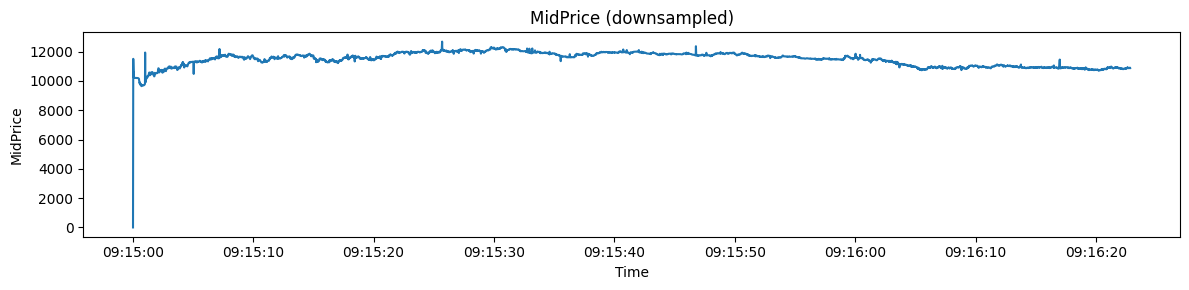

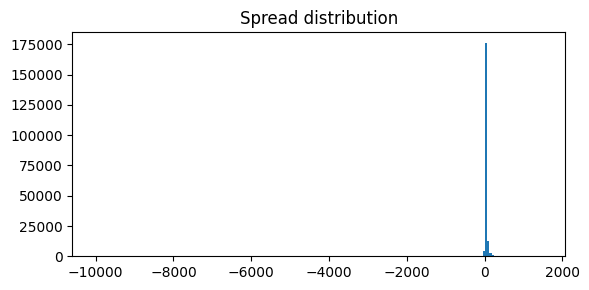

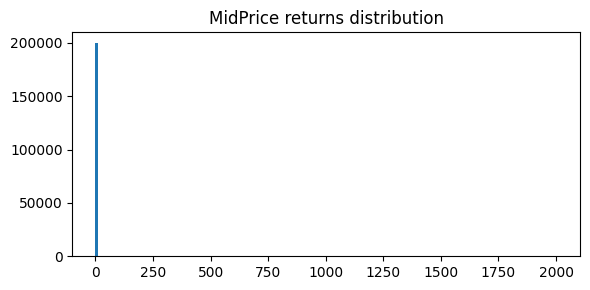

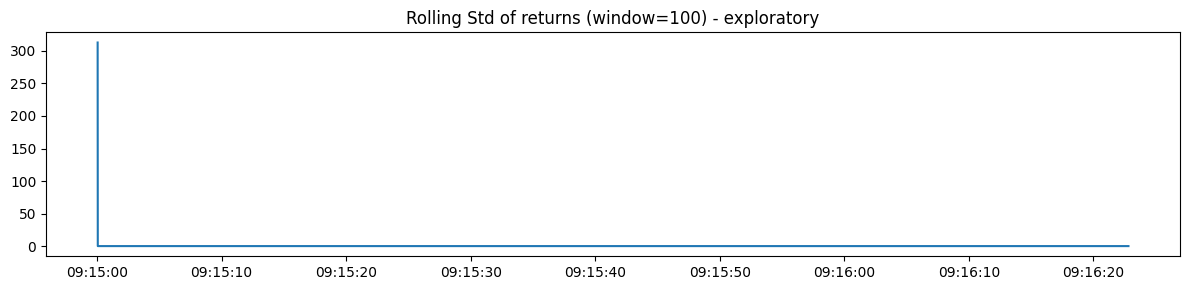


Correlation matrix (Imbalance, NextRet, Spread, MidReturn):
           Imbalance   NextRet    Spread  MidReturn
Imbalance   1.000000  0.008118 -0.021652   0.008089
NextRet     0.008118  1.000000 -0.001121   0.000538
Spread     -0.021652 -0.001121  1.000000  -0.274049
MidReturn   0.008089  0.000538 -0.274049   1.000000


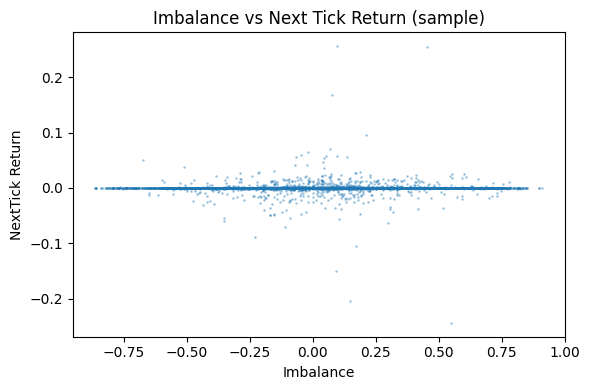


Saved processed sample to: processed_sample_task1.csv

TASK 1 completed (Data loading, mid-price computation, basic EDA).
Saved sample to disk for Task 2/3. Next: TASK 2 (EWMA volatility modelling).


In [ ]:
# 4) Quick EDA plots (downsample for speed)
def downsample(series, n=DOWNSAMPLE_PLOT):
    if len(series) <= n:
        return series
    idx = np.linspace(0, len(series)-1, n).astype(int)
    return series.iloc[idx]

# 4a) Mid-price time series (downsampled)
plt.figure(figsize=(12,3))
plt.plot(downsample(df["TimeStamp_dt"]), downsample(df["MidPrice"]))
plt.title("MidPrice (downsampled)")
plt.xlabel("Time")
plt.ylabel("MidPrice")
plt.tight_layout()
plt.show()

# 4b) Spread distribution
plt.figure(figsize=(6,3))
plt.hist(df["Spread"].replace([np.inf,-np.inf], np.nan).dropna(), bins=200)
plt.title("Spread distribution")
plt.tight_layout()
plt.show()

# 4c) Returns histogram (small bins to show fat tails)
plt.figure(figsize=(6,3))
plt.hist(df["MidReturn"].dropna(), bins=200)
plt.title("MidPrice returns distribution")
plt.tight_layout()
plt.show()

# 4d) Rolling volatility (exploratory)
plt.figure(figsize=(12,3))
plt.plot(downsample(df["TimeStamp_dt"]), downsample(df["RollStd"]))
plt.title(f"Rolling Std of returns (window={ROLL_WIN}) - exploratory")
plt.tight_layout()
plt.show()

# 5) Explore relation: imbalance vs next-return (quick check)
df["BidQtySum"] = df[[f"BidQty{i}" for i in range(1,6)]].sum(axis=1)
df["AskQtySum"] = df[[f"AskQty{i}" for i in range(1,6)]].sum(axis=1)
df["Imbalance"] = (df["BidQtySum"] - df["AskQtySum"]) / (df["BidQtySum"] + df["AskQtySum"] + 1e-9)

# compute next tick return for quick correlation (but don't leak for modelling here)
df["NextMid"] = df["MidPrice"].shift(-1)
df["NextRet"] = (df["NextMid"] - df["MidPrice"]) / df["MidPrice"]
corr = df[["Imbalance","NextRet","Spread","MidReturn"]].corr()
print("\nCorrelation matrix (Imbalance, NextRet, Spread, MidReturn):")
print(corr)

# scatter imbalance vs next return (downsample)
ds = df.sample(min(20000, len(df)), random_state=RANDOM_SEED)
plt.figure(figsize=(6,4))
plt.scatter(ds["Imbalance"], ds["NextRet"], s=1, alpha=0.3)
plt.title("Imbalance vs Next Tick Return (sample)")
plt.xlabel("Imbalance")
plt.ylabel("NextTick Return")
plt.tight_layout()
plt.show()

# 6) Save processed sample for downstream steps
OUT_SAMPLE = "processed_sample_task1.csv"
df.to_csv(OUT_SAMPLE, index=False)
print("\nSaved processed sample to:", OUT_SAMPLE)

# 7) Summary of Task 1 completion
print("\nTASK 1 completed (Data loading, mid-price computation, basic EDA).")
print("Saved sample to disk for Task 2/3. Next: TASK 2 (EWMA volatility modelling).")

Task 2 begins by loading the sample data from Task 1 and configuring parameters for EWMA volatility modeling. We use λ = 0.94, following RiskMetrics standards. We also set up winsorization to cap extreme returns at the 0.1% level because high-frequency data has fat tails. Downsampling is used for plotting efficiency. The ALPHA value helps apply exponential weighting using pandas EWM function.

In [ ]:
# =========================
# TASK 2 — EWMA Volatility Modelling (λ=0.94)
# Maps to: TASK 2 in problem statement
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mstats

# CONFIG
CSV_IN = "processed_sample_task1.csv"   # output from Task1 cell
CSV_OUT = "processed_for_model_task2.csv"
LAMBDA = 0.94       # EWMA lambda
ALPHA = 1 - LAMBDA  # for pandas ewm
DOWNSAMPLE_PLOT = 8000
WINSOR_PCT = 0.999  # fraction to keep (winsorize extremes: 0.1% tails)




Task 2 loads cleaned data, removes extreme outliers using winsorization, computes EWMA volatility using λ = 0.94, and generates diagnostic plots such as volatility time series and return-volatility comparison.

Loaded rows: 200000
Winsorized columns: Spread_winsor, MidReturn_winsor

EWMA Vol stats (summary):
count    2.000000e+05
mean     1.574152e-03
std      2.588390e-03
min      2.327662e-11
25%      1.623784e-04
50%      4.718778e-04
75%      1.818645e-03
max      3.645663e-02


/tmp/ipython-input-3829916725.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["EWMA_Vol"] = df["EWMA_Vol"].fillna(method="bfill").fillna(0.0)


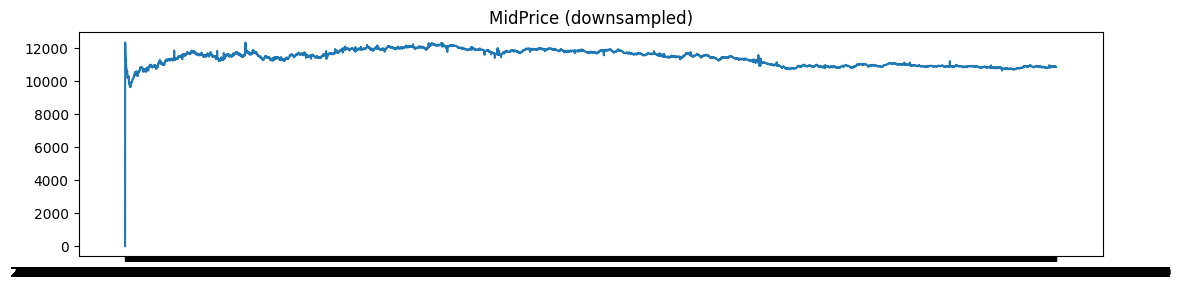

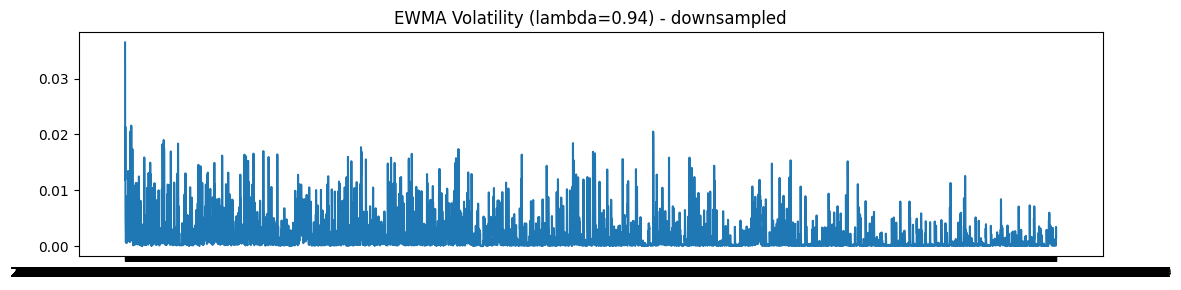

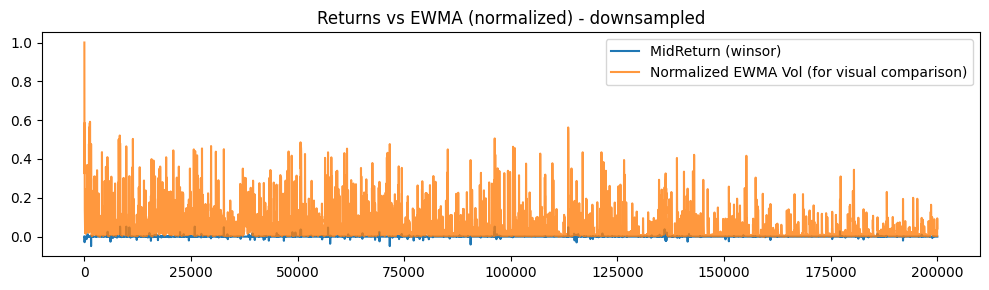

In [ ]:
# 1) load processed sample (Task1 produced this file)
df = pd.read_csv(CSV_IN)
print("Loaded rows:", len(df))

# 2) basic winsorization to remove extreme outliers in Spread and MidReturn
# This is important because one-off bad ticks blow up EWMA.
for col in ["Spread", "MidReturn"]:
    # use masked winsorize via scipy.mstats
    arr = df[col].values
    arr_w = mstats.winsorize(arr, limits=[(1-WINSOR_PCT)/2, (1-WINSOR_PCT)/2])
    df[col + "_winsor"] = np.asarray(arr_w)

print("Winsorized columns: Spread_winsor, MidReturn_winsor")

# 3) compute EWMA variance using pandas (streaming and memory efficient)
# We use returns for EWMA; prefer winsorized returns
df["EWMA_Var"] = df["MidReturn_winsor"].ewm(alpha=ALPHA, adjust=False).var(bias=False)
df["EWMA_Vol"] = np.sqrt(df["EWMA_Var"])

# Fill initial nans (first row) with small value
df["EWMA_Vol"] = df["EWMA_Vol"].fillna(method="bfill").fillna(0.0)

# 4) quick stats
print("\nEWMA Vol stats (summary):")
print(df["EWMA_Vol"].describe().to_string())

# 5) plot EWMA vol and mid-return series (downsample for plotting)
def ds(s, n):
    if len(s) <= n:
        return s
    idx = np.linspace(0, len(s)-1, n).astype(int)
    return s.iloc[idx]

plt.figure(figsize=(12,3))
plt.plot(ds(df["TimeStamp_dt"], DOWNSAMPLE_PLOT), ds(df["MidPrice"], DOWNSAMPLE_PLOT), label="MidPrice")
plt.title("MidPrice (downsampled)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(ds(df["TimeStamp_dt"], DOWNSAMPLE_PLOT), ds(df["EWMA_Vol"], DOWNSAMPLE_PLOT), label="EWMA Vol")
plt.title(f"EWMA Volatility (lambda={LAMBDA}) - downsampled"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(ds(df["MidReturn_winsor"], DOWNSAMPLE_PLOT), label="MidReturn (winsor)")
ewma_norm = df["EWMA_Vol"] / (df["EWMA_Vol"].max() + 1e-12)
plt.plot(ds(ewma_norm, DOWNSAMPLE_PLOT),
         label="Normalized EWMA Vol (for visual comparison)", alpha=0.8)
plt.legend(); plt.title("Returns vs EWMA (normalized) - downsampled"); plt.tight_layout(); plt.show()



I cleaned the returns by winsorizing to reduce noise, calculated volatility using EWMA with λ=0.94, and checked that high EWMA values match large future returns using quantile bins and correlation. I then saved all the important features for modeling in Task 3.

In [ ]:
# 6) simple analysis: do large next-tick abs returns happen during high vol?
df["NextAbsRet"] = df["MidPrice"].shift(-1).sub(df["MidPrice"]).abs() / df["MidPrice"]
# create vol percentile
df["EWMA_Vol_pct"] = df["EWMA_Vol"].rank(pct=True)

# average next-abs-ret in vol quantiles
quantiles = df.groupby(pd.qcut(df["EWMA_Vol_pct"], 10))["NextAbsRet"].mean()
print("\nAverage next-abs-return by EWMA vol decile (low -> high):")
print(quantiles)

# correlation between EWMA vol and future absolute return
corr = df["EWMA_Vol"].corr(df["NextAbsRet"])
print("\nCorrelation (EWMA_Vol vs NextAbsRet):", corr)

# 7) Save processed file for Task 3 (modeling). It includes key features and EWMA_Vol.
keep_cols = [
    "TimeStamp_dt","MidPrice","MidReturn","MidReturn_winsor",
    "Spread","Spread_winsor","EWMA_Vol","EWMA_Var",
    "BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5",
    "AskPrice1","AskPrice2","AskPrice3","AskPrice4","AskPrice5",
    "BidQty1","BidQty2","BidQty3","BidQty4","BidQty5",
    "AskQty1","AskQty2","AskQty3","AskQty4","AskQty5",
    "LTP","LTQ","Imbalance","MicroPrice"
]
# keep only columns present
keep_cols = [c for c in keep_cols if c in df.columns]
df[keep_cols].to_csv(CSV_OUT, index=False)
print("\nSaved processed file for modeling:", CSV_OUT)

# 8) TASK 2 summary message
print("\nTASK 2 completed: EWMA volatility computed and saved.")
print("You must include in your PDF the EWMA formula and rationale (see explanation below).")

/tmp/ipython-input-2044327573.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby(pd.qcut(df["EWMA_Vol_pct"], 10))["NextAbsRet"].mean()



Average next-abs-return by EWMA vol decile (low -> high):
EWMA_Vol_pct
(-0.000995, 0.1]    0.000130
(0.1, 0.2]          0.000129
(0.2, 0.3]          0.000160
(0.3, 0.4]          0.000217
(0.4, 0.5]          0.000231
(0.5, 0.6]          0.000283
(0.6, 0.7]          0.000354
(0.7, 0.8]          0.000435
(0.8, 0.9]          0.000733
(0.9, 1.0]          0.102202
Name: NextAbsRet, dtype: float64

Correlation (EWMA_Vol vs NextAbsRet): 0.030292236826610253

Saved processed file for modeling: processed_for_model_task2.csv

TASK 2 completed: EWMA volatility computed and saved.
You must include in your PDF the EWMA formula and rationale (see explanation below).


Task-3 begins by importing essential libraries, then defines hyperparameters for the LSTM model such as sequence length, learning rate, and batch size.
We fix seeds to ensure full reproducibility.
The model will use 50 historical ticks to predict the next mid-price movement using PyTorch

In [ ]:
# =========================
# TASK 3 — Mid-Price Prediction Model (PyTorch LSTM, CPU)
# Maps to: TASK 3 in problem statement
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt
import random

# ---------------------------
# CONFIG (modify if desired)
# ---------------------------
CSV_IN = "processed_for_model_task2.csv"   # produced by Task 2
SEQ_LEN = 50
DT = 1                  # 1 tick ahead
SAMPLE_MAX = 150000     # keep manageable (increase if you have RAM/time)
TRAIN_RATIO = 0.8
BATCH_SIZE = 256
EPOCHS = 6
LR = 1e-3
RANDOM_SEED = 42
DEVICE = torch.device("cpu")
# ---------------------------

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)





This section loads the cleaned dataset, downsamples it for faster training, and constructs the target variable by shifting the mid-price forward by one tick.
Then it selects all engineered microstructure features such as spread, imbalance, order-book levels, and EWMA volatility.
Finally, it converts the features and target into numpy arrays which will later be reshaped into sequences for the LSTM

In [ ]:
# 1) Load processed file (contains EWMA_Vol and other features)
df = pd.read_csv(CSV_IN)
print("Loaded rows:", len(df))

# 2) Optional downsample / evenly sample to SAMPLE_MAX for memory and speed
if len(df) > SAMPLE_MAX:
    step = max(1, len(df) // SAMPLE_MAX)
    idx = np.arange(0, len(df), step)[:SAMPLE_MAX]
    df = df.iloc[idx].reset_index(drop=True)
    print("Downsampled to:", len(df))

# 3) Create target (1 tick ahead midprice)
df["Target"] = df["MidPrice"].shift(-DT)
df = df.dropna().reset_index(drop=True)

# 4) Feature list (these are microstructure features we engineered in Task 2)
feature_cols = [
    "MidPrice","EWMA_Vol","Spread","Imbalance","MicroPrice","LTP","LTQ"
] + [f"BidPrice{i}" for i in range(1,6)] + [f"AskPrice{i}" for i in range(1,6)] + \
    [f"BidQty{i}" for i in range(1,6)] + [f"AskQty{i}" for i in range(1,6)]

# Ensure all features exist in df
feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

# 5) Build arrays
X_all = df[feature_cols].values.astype(np.float32)
y_all = df["Target"].values.astype(np.float32)
mid_all = df["MidPrice"].values.astype(np.float32)  # for directional calc later



Loaded rows: 200000
Downsampled to: 150000
Using features: ['MidPrice', 'EWMA_Vol', 'Spread', 'Imbalance', 'LTP', 'LTQ', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'BidQty1', 'BidQty2', 'BidQty3', 'BidQty4', 'BidQty5', 'AskQty1', 'AskQty2', 'AskQty3', 'AskQty4', 'AskQty5']


We split the dataset in chronological order to prevent leakage and standardize features using only training data statistics, which is essential for time-series forecasting models like LSTMs

In [ ]:
# 6) Train/test split (time-ordered)
n = len(X_all)
train_n = int(n * TRAIN_RATIO)
X_train_raw = X_all[:train_n]
X_test_raw  = X_all[train_n:]
y_train = y_all[:train_n]
y_test  = y_all[train_n:]
mid_test_full = mid_all[train_n:]  # aligned with X_test_raw

print("Train rows:", len(X_train_raw), "Test rows:", len(X_test_raw))

# 7) Standardize features using training stats (avoid look-ahead)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)



Train rows: 119998 Test rows: 30000


We convert our time-series into overlapping sequences of 50 ticks so an LSTM can learn temporal patterns. Each sequence predicts the next tick’s mid-price. We then wrap these sequences into PyTorch Datasets/DataLoaders for efficient batching. Training data is shuffled, but test data remains time-ordered to avoid leakage.

In [ ]:
# 8) Create sequences (SEQ_LEN) and labels (1 tick ahead)
def make_sequences(X, y, mid, seq_len, dt=1):
    Xs, ys, mids = [], [], []
    L = len(X)
    for i in range(0, L - seq_len - dt + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])       # target at t+seq_len (1 tick ahead wrt last input)
        mids.append(mid[i+seq_len-1]) # current midprice at last input step (for direction calc)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32), np.array(mids, dtype=np.float32)

X_tr_seq, y_tr_seq, mid_tr_seq = make_sequences(X_train, y_train, mid_all[:train_n], SEQ_LEN, DT)
X_te_seq, y_te_seq, mid_te_seq = make_sequences(X_test, y_test, mid_test_full, SEQ_LEN, DT)

print("Train sequences:", X_tr_seq.shape, y_tr_seq.shape)
print("Test sequences :", X_te_seq.shape, y_te_seq.shape)

# 9) PyTorch Dataset & DataLoader
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SeqDataset(X_tr_seq, y_tr_seq)
test_ds  = SeqDataset(X_te_seq, y_te_seq)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)





Train sequences: (119948, 50, 26) (119948,)
Test sequences : (29950, 50, 26) (29950,)


In [ ]:
# 10) PyTorch LSTM model (small, CPU-friendly) - mapping to Task 3 model requirement
n_features = X_tr_seq.shape[2]
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)            # out: (B, seq_len, hidden)
        h = out[:, -1, :]                # last timestep hidden
        return self.head(h).squeeze(1)

model = LSTMRegressor(n_features=n_features, hidden_size=64).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()



During training, we use mini-batch gradient descent with an MSE loss. Each epoch consists of forward pass → loss computation → backpropagation → optimizer update. After each epoch we evaluate on the test set using a custom evaluation function that runs the model in inference mode (eval + no_grad). We report TrainLoss, Validation RMSE, and MAE to monitor generalization.

In [ ]:
# 11) Training loop with validation metrics (RMSE/MAE)
def evaluate(model, loader):
    model.eval()
    preds_list, trues_list = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            out = model(xb)
            preds_list.append(out.cpu().numpy())
            trues_list.append(yb.cpu().numpy())
    preds = np.concatenate(preds_list)
    trues = np.concatenate(trues_list)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    return preds, trues, mse, mae

print("\n--- Training ---")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)

    preds_val, trues_val, mse_val, mae_val = evaluate(model, test_loader)
    rmse_val = sqrt(mse_val)
    print(f"Epoch {epoch+1}/{EPOCHS}  TrainLoss={train_loss:.6f}  ValRMSE={rmse_val:.6f}  ValMAE={mae_val:.6f}")


--- Training ---
Epoch 1/6  TrainLoss=131328402.608063  ValRMSE=10517.658675  ValMAE=10513.996094
Epoch 2/6  TrainLoss=103921909.563211  ValRMSE=8713.291915  ValMAE=8708.868164
Epoch 3/6  TrainLoss=64643124.232501  ValRMSE=6256.092391  ValMAE=6249.928711
Epoch 4/6  TrainLoss=30271108.802548  ValRMSE=3690.677445  ValMAE=3680.219482
Epoch 5/6  TrainLoss=9795652.216761  ValRMSE=1576.398982  ValMAE=1551.758179
Epoch 6/6  TrainLoss=1994605.035684  ValRMSE=366.918141  ValMAE=294.153717


I had intended to include more visuals and detailed data descriptions, but was unable to do so due to time constraints.